# Titanic Dataset Analysis - Part 2

Part 2 of the analysis examines the data using correlation, linear regression models, and decision trees.

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

%matplotlib inline

filename = 'titanic_data.csv'
titanic_df = pd.read_csv(filename)
titanic_df['Age'] = titanic_df.groupby('Survived')['Age'].transform(lambda x: x.fillna(x.mean()))
titanic_df['Embarked'] = titanic_df['Embarked'].fillna('U')
titanic_df['Cabin'] = titanic_df['Cabin'].fillna(0)
titanic_df.isnull().sum() #check for missing values

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

## Correlation and Linear Regression

In [2]:
# correlation
titanic_df['Age'].corr(titanic_df['Survived'])

-0.085363872416497691

The correlation is weak and negative.

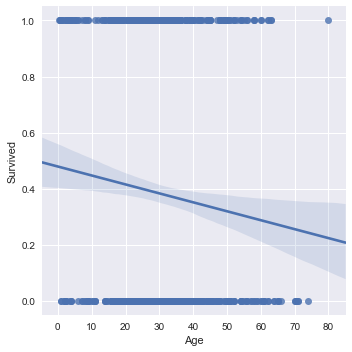

In [3]:
# linear regression
sns.lmplot(x="Age", y="Survived", data=titanic_df)

The linear regression line confirms a slight negative relationship.

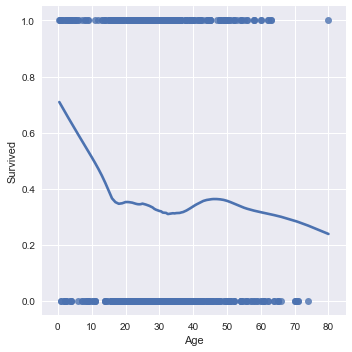

In [4]:
# lowess curve
sns.lmplot(x="Age", y="Survived", data=titanic_df, lowess=True)

From the lowess curve, we can see that the line has three different slopes for ages 0-18, 18-45, and 45-80 approximately. In part 1, the survivors were cross-tabluated against binned ages that where the boundaries were guessed. This graph is a better way to see where those boundaries are.

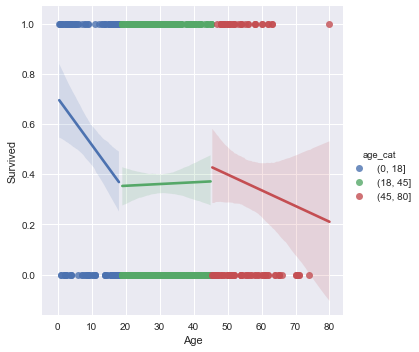

In [5]:
titanic_df['age_cat'] = pd.cut(titanic_df['Age'], bins=[0, 18, 45, 80])
sns.lmplot(x="Age", y="Survived", hue="age_cat", data=titanic_df, 
           truncate=True)

The 'Age' is cut into three categories. Then, create and plot the linear models for each category.

## Decision Tree

In [28]:
#titanic_df['Male'] = pd.get_dummies(titanic_df['Sex'], drop_first = True)
#titanic_df['Embarked'] = pd.get_dummies(titanic_df['Embarked'], drop_first = True)

features = ['Pclass', 'Male', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = titanic_df[features]

# one-hot encode features
X = pd.get_dummies(X, drop_first = True)

y = titanic_df['Survived']

# set up the model and run it
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

To make it easier to view in this notebook, the max_depth is set to 3. Hyper-parameter estimation will be done below.

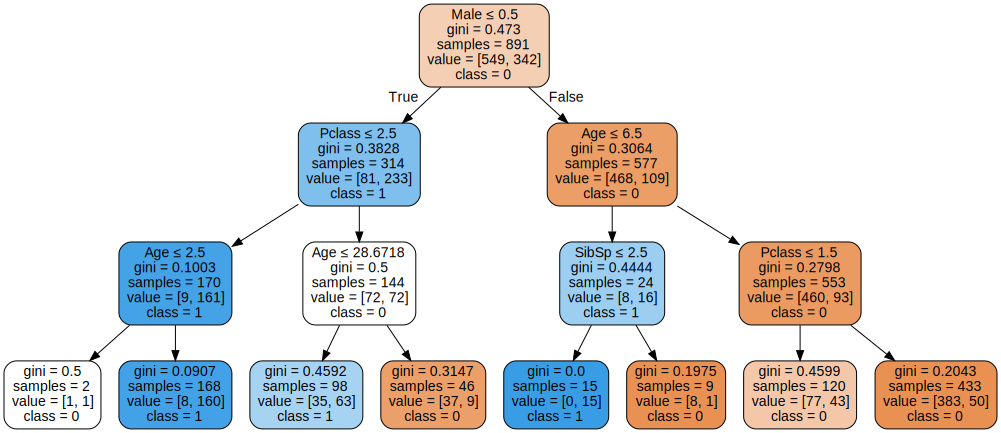

In [29]:
# Visualize the tree
classes = ['0', '1']
dot_data = export_graphviz(clf, out_file=None, 
                         feature_names=X.columns.values,  
                         class_names=classes,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
graph

Here is how to read one branch of the decision tree. The root starts with whether the person is female (Male <= 0.5). If female, check the passenger class, if the passenger class is 1 or 2 (Pclass <= 2.5) and the age is less than or equal to 2.5 the person did not survive. It the age was greater, she survived.

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Split the data into 80% train and 20% test.

In [35]:
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'max_depth': [5, 10, 15, 20], 'min_samples_leaf': [1, 5, 10, 15], 'min_samples_split': [2, 5, 10, 15]}
]

clf = GridSearchCV(DecisionTreeClassifier(), param_grid)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'min_samples_split': [2, 5, 10, 15], 'max_depth': [5, 10, 15, 20], 'min_samples_leaf': [1, 5, 10, 15]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Define the training grid and run the grid search.

In [36]:
print("Best parameters set found on development set:")
print(clf.best_params_)

Best parameters set found on development set:
{'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 5}


In [37]:
from sklearn.metrics import accuracy_score

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

('The training accuracy is', 0.901685393258427)
('The test accuracy is', 0.86033519553072624)
